In [3]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tqdm

In [4]:
file_path = r"/Users/Henry/Desktop/NYU/Spring 2019/Active Portfolio Management/Final projects/Data"

In [5]:
FactorsMatrix = []
dfs = []
dates = []
# Construct a series which contains all stocks ID
stockID = set()
style_factors = ['BETA', 'MOMENTUM', 'SIZE', 'VOL']
alpha_factors = ['tir','td']
returns_list = ['R']
factors_list = set()
# Read data
for i in tqdm.tqdm_notebook(range(2007,2018)):
    path = file_path + '/apt-' + str(i)
    files = os.listdir(path)
    # Data processing
    for file in files:
        df = pd.read_csv(path + '/' + file, sep = '|', index_col = 'ID')
        dates.extend([df['T'].iloc[0]])
        # Anomaly on that day
        if df['T'].iloc[0] == '2013-12-31':
            continue
        temp_idx = set(df.index)
        stockID = stockID.union(temp_idx)
        dummies = pd.get_dummies(df['GICCODE'])
        FactorsMatrix.extend([df[alpha_factors+style_factors].join(dummies).fillna(0)])
        dfs.extend([df[['R','RESVOL','ADVP']]])

dates.remove('2013-12-31')

In [6]:
stockID = list(stockID)
factors_list = FactorsMatrix[0].columns

In [7]:
# Drop those factors which do not have values across all periods
for i in range(1,len(FactorsMatrix)):
    # construct common factors list
    factors_list = factors_list.intersection(FactorsMatrix[i].columns)

In [8]:
for i in range(len(FactorsMatrix)):
    # Discard factors
    FactorsMatrix[i] = FactorsMatrix[i].loc[:,factors_list]

In [9]:
# from float 64 to float 32 to speed up speed
for i in range(len(FactorsMatrix)):
    columns = ['tir','td','BETA', 'MOMENTUM', 'SIZE', 'VOL']
    FactorsMatrix[i][columns] = FactorsMatrix[i][columns].astype(np.float32)
    dfs[i] = dfs[i].astype(np.float32)

In [24]:
# factors regression, OLS/WLS
# data is a list of dataframes
def FactorsOLS(facMat, dfs, stockID):
    #res = pd.DataFrame(index = stockID)
    f_rets = pd.DataFrame()
    for i in tqdm.tqdm_notebook(range(len(facMat))):
        X = facMat[i].values
        Y = dfs[i][returns_list].values
        X_I = sm.add_constant(X)
        model = sm.OLS(Y,X_I).fit()
        f_ret = pd.DataFrame(model.params[1:])
        f_rets = pd.concat([f_rets,f_ret], axis=1, sort=False)
        #res = pd.concat([res, pd.DataFrame(model.resid, index = facMat[i].index)], axis=1, sort=False)
    f_rets.index = factors_list
    #res.columns = dates
    return f_rets.T

# to handle outliers
def TrimmedWeight(weight, low_quantile=0.1, top_quantile=0.9):
    threshold = weight.quantile([low_quantile, top_quantile]).values
    weight[weight<threshold[0]] = threshold[0]
    weight[weight>threshold[1]] = threshold[1]
    return weight

def FactorsWLS(facMat, dfs, stockID):
    #res = pd.DataFrame(index = stockID)
    f_rets = pd.DataFrame()
    for i in tqdm.tqdm_notebook(range(len(facMat))):
        X = facMat[i].values
        Y = dfs[i][returns_list].values
        X_I = sm.add_constant(X)
        # Use 1/(RESVOL)^2 as weights
        weight = 1/pow(dfs[i]['RESVOL'],2)
        weight = TrimmedWeight(weight, 0.1, 0.9)
        model = sm.WLS(Y,X_I,weights=weight).fit()
        f_ret = pd.DataFrame(model.params[1:])
        f_rets = pd.concat([f_rets,f_ret], axis=1, sort=False)
        #res = pd.concat([res, pd.DataFrame(model.resid, index = facMat[i].index)], axis=1, sort=False)
    f_rets.index = factors_list
    #res.columns = dates
    return f_rets.T

# Calculate annualized residual variance using EWMA
def res_Var(res, halflife):
    #res = res.fillna(method='bfill')
    resVar = res.ewm(halflife=halflife).var()
    #resVar = resVar.fillna(0.05)
    resVar = resVar.fillna(method='bfill')
    return resVar

In [ ]:
# Problem 1 a)
f_rets_OLS = FactorsOLS(FactorsMatrix, dfs, stockID)
f_rets_WLS = FactorsWLS(FactorsMatrix, dfs, stockID)

In [139]:
from datetime import datetime
d = [datetime.strptime(x,'%Y-%m-%d')  for x in dates]

In [246]:
f_rets_OLS.index = range(n)
f_rets_WLS.index = range(n)

/Users/Henry/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


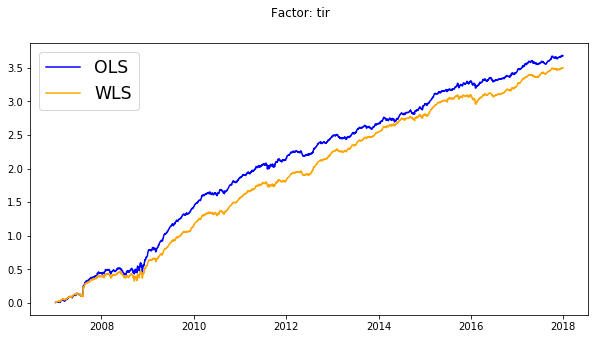

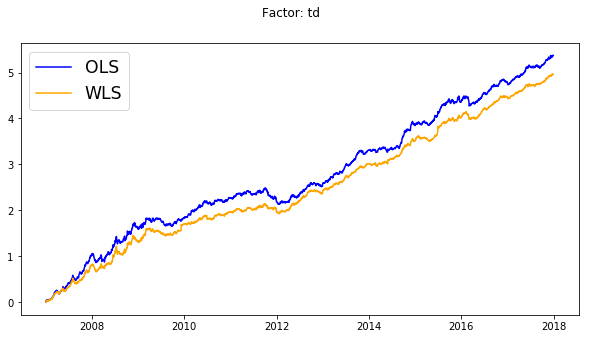

In [41]:
# Problem 1 b)
for factor_name in alpha_factors:
    fig = plt.figure(figsize=(10,5))
    fig.suptitle(f'Factor: {factor_name}')
    plt.plot(d, f_rets_OLS[factor_name].cumsum().values, label='OLS', color='blue')
    plt.plot(d, f_rets_WLS[factor_name].cumsum().values, label='WLS', color='orange')
    plt.legend(loc='best', fontsize='xx-large')

In [253]:
meanAlphaRet = pd.DataFrame([f_rets_OLS.mean(),f_rets_WLS.mean()], index = ['OLS', 'WLS'])


In [254]:
# Problem 1 c)
meanAlphaRet[alpha_factors]

,tir,td
OLS,0.001330,0.001939
WLS,0.001265,0.001794


In [125]:
def SMWLemma(resVar, X, F):
    # We use Sherman-Morrison-Woodbury lemma here so that we dont need to form full Sigma
    # SMW: (A + UCV)-1 = A-1 - A-1U(C-1 + VA-1U)-1VA-1
    # In our case: Sigma = (D = XFX'), so
    # Sigma-1 = (D + XFX')-1, A = D, U = X, C = F, V = X'

    A_inv = np.diag(1/resVar)
    U = X
    C = F
    V = X.T
    
    # A-1
    f1 = A_inv
    # A-1 * U
    f2 = A_inv.dot(U)
    # (C-1 + VA-1U)-1
    f3 = np.linalg.inv(np.linalg.inv(C) + V.dot(A_inv.dot(U)))
    # VA-1
    f4 = V.dot(A_inv)
    
    return f1, f2, f3, f4

In [126]:
def MarkowitzOptimize(resVar, X, F, alpha, kappa=1e-2):
    # Objective: argmax(h): h'alpha - (k/2)*h'*Sigma*h - 10bp * h^2 / (0.01 * advp)
    # Solution: (Sigma-1 * alpha)/kappa
    
    f1, f2, f3, f4 = SMWLemma(resVar, X, F)
    
    return (f1.dot(alpha) - f2.dot(f3.dot(f4.dot(alpha))))/kappa

In [168]:
def PnL_OLS(FacMat, dfs, f_rets, start, end):
    #resVar = res_Var(res, halflife)
    pos = pd.DataFrame(np.zeros(len(stockID)),index=stockID)
    PnL_before = []
    transactCost = []
    hagg = []
    hAvg = 0
    for i in tqdm.tqdm_notebook(range(start,end)):
        # alpha factors
        alpha = FacMat[i][alpha_factors].sum(axis=1).values[:,np.newaxis]
        # residual variance at time t
        resV = pow(dfs[i]['RESVOL'].values,2)
        # design matrix X
        X = FacMat[i].values
        # Calculated expanding window covariance matrix for factor returns
        F = f_rets.iloc[:i, :].cov().values
        # Optimal portfolio
        h = MarkowitzOptimize(resV, X, F, alpha, kappa = 1e-02)
        # Average daily trading volume times prices
        advp = dfs[i]['ADVP']
        # Stocks existing today
        stocksIndex = FacMat[i].index
        updatedPos = pd.DataFrame(h,index=stocksIndex)
        pos = pd.concat([pos, updatedPos], axis=1, sort=False)
        pos = pos.fillna(0)
        posChg = pos.loc[stocksIndex].iloc[:,i-start+1] - pos.loc[stocksIndex].iloc[:,i-start]
#         # stockID for stocks trade more than trading volume
#         idx = stocksIndex[posChg > advp]
#         # If the optimal h attemps to trade more than advp, set to 70% of trading volume
#         posChg[idx] = advp[idx] * 0.7
#         # updated the new position
#         pos.loc[idx].iloc[:,i-start] = posChg[idx] + pos.loc[idx].iloc[:,i-1-start]
#         updatedPos = pos.loc[stocksIndex].iloc[:,i-start].values
        # trsanction cost is 10bp * posChg**2 / (0.01 * advp(i))
        transactCost = np.append(transactCost, (10/10000) * np.sum(pow(posChg,2) / (0.01 * advp)))
        # Compute daily PnL
        PnL_before = np.append(PnL_before, np.dot(updatedPos.T, dfs[i][returns_list]))
        hAvg = (hAvg*(i-1) + np.sum(abs(updatedPos.values)))/i
        hagg.extend([updatedPos.values])
    PnL_before = pd.DataFrame(PnL_before, index=range(len(PnL_before)))
    transactCost = pd.DataFrame(transactCost, index=range(len(transactCost)))
    PnL_after = PnL_before - transactCost
    return PnL_before, PnL_after, transactCost, hAvg, pos, hagg


In [169]:
# Start trading 200 days after intial dat, to give sufficient date to estimate covariance matrix
start = 200
end = len(FactorsMatrix)

In [170]:
pnl_before,pnl_after,cost,havg,pos,hagg = PnL_OLS(FactorsMatrix,dfs,f_rets_OLS,start,end)

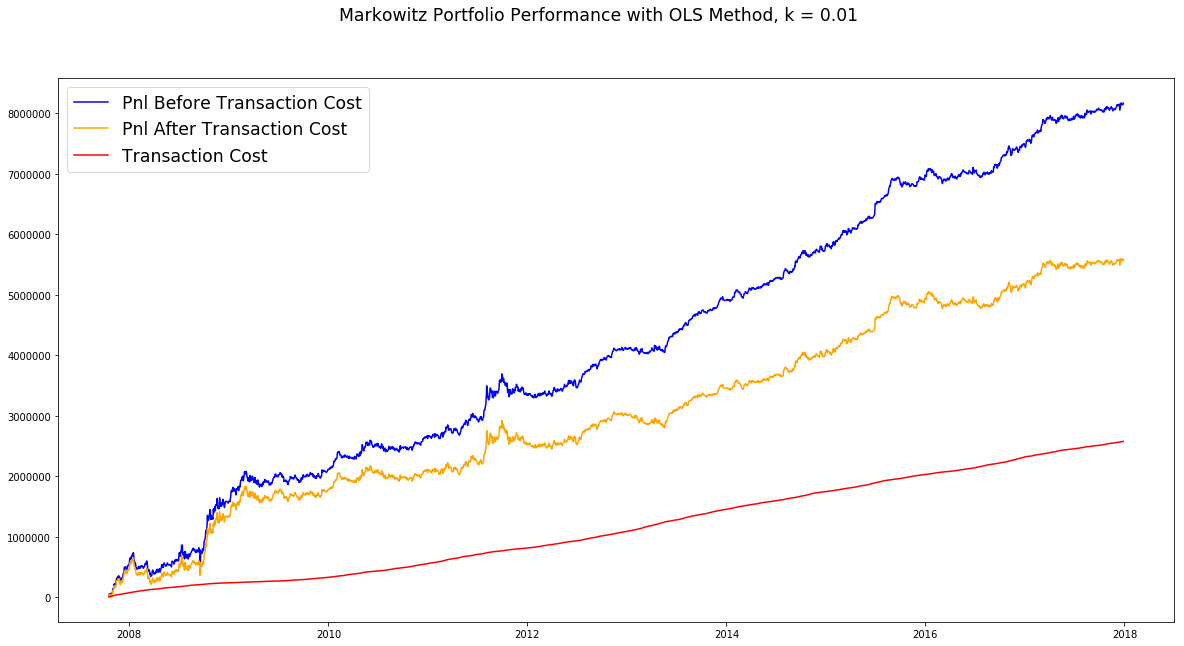

In [171]:
fig = plt.figure(figsize=(20,10))
fig.suptitle(f'Markowitz Portfolio Performance with OLS Method, k = 0.01', fontsize='xx-large')
plt.plot(d[start:], pnl_before.cumsum().values, label='Pnl Before Transaction Cost', color='blue')
plt.plot(d[start:], pnl_after.cumsum().values, label='Pnl After Transaction Cost', color='orange')
plt.plot(d[start:], cost.cumsum().values, label='Transaction Cost', color='red')
plt.legend(loc='best', fontsize='xx-large')

In [179]:
def riskDecomposition(FacMat, dfs, f_rets, pos, start, end):
    ratioAlpha = []
    ratioIdio = []
    ratioNonAlpha = []
    for i in tqdm.tqdm_notebook(range(start,end)):
        F = f_rets.iloc[:i,:].cov().values
        X = FacMat[i].values
        resVar = pow(dfs[i]['RESVOL'],2)
        D = np.diag(resVar)
        # position
        h=pos[i-start]
        
        # total variance
        totVar = h.T.dot(X.dot(F.dot(X.T))).dot(h) + h.T.dot(D).dot(h)
        # ratio of idiosyncratic variance to total variance
        idioVar = h.T.dot(D).dot(h) / totVar
        # ratio variance attributed to alpha variance to total variance
        alphaVar = (h.T.dot(X))[:,:2].dot((F.dot(X.T))[:2,:]).dot(h) / totVar
        # ratio of variance attributed to the non-alpha factors 
        nonAlphaVar = 1 - idioVar - alphaVar
        
        ratioAlpha = np.append(ratioAlpha, alphaVar)
        ratioIdio = np.append(ratioIdio, idioVar)
        ratioNonAlpha = np.append(ratioNonAlpha, nonAlphaVar)
        
    return ratioAlpha, ratioIdio, ratioNonAlpha

In [ ]:
ratioAlpha, ratioIdio, ratioNonAlpha = riskDecomposition(FactorsMatrix, dfs, f_rets_OLS, hagg, start, end)

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.suptitle(f'Risk Decomposition', fontsize='xx-large')
plt.plot(d[start:], ratioAlpha, label='Alpha', color='blue')
plt.plot(d[start:], ratioIdio, label='Idiosyncratic', color='orange')
plt.plot(d[start:], ratioNonAlpha, label='Non-Alpha', color='red')
plt.legend(loc='upper left', fontsize='xx-large')

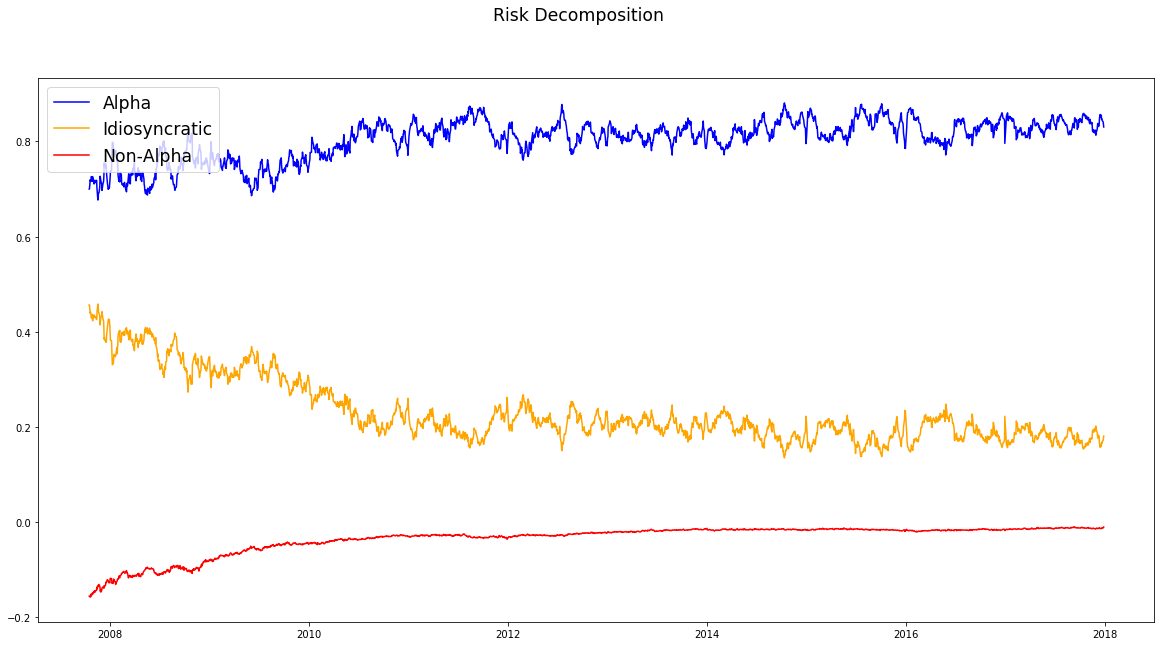

In [38]:
def Sigma_inv(X, F, D, Y):
    # We use Sherman-Morrison-Woodbury lemma here so that we dont need to form full Sigma
    # SMW: (A + UCV)-1 = A-1 - A-1U(C-1 + VA-1U)-1VA-1
    # In our case: Sigma = (D = XFX'), so
    # Sigma-1 = (D + XFX')-1, A = D, U = X, C = F, V = X'
    # Sigma-1 * Y = A-1Y - A-1U(C-1 + VA-1U)-1VA-1Y

    A_inv = np.eye(len(X)) * (1/D)
    U = X
    C = F
    V = X.T

    # A-1 * Y
    f1 = A_inv.dot(Y)
    # A-1 * U
    f2 = A_inv.dot(U)
    # (C-1 + VA-1U)-1
    f3 = np.linalg.inv(np.linalg.pinv(C) + V.dot(A_inv.dot(U)))
    # VA-1 * alpha
    f4 = V.dot(A_inv).dot(Y)

    return f1 - f2.dot(f3).dot(f4)

In [71]:
def EMAlgorithm(BETA, THETA, SIGMA_Sq, b1, b2, Sum_Tr, c, s, X, r):
    # Parameters to be updated {BETA, THETA, SIGMA^2}
    # Design matrix at time s: X(s)
    # returns at time s: r(s)
    # BETA: Estimate of BETA(s) at time s-1
    # THETA: Estimate of THETA(s) at time s-1
    # SIGMA_Sq: Estimate of SIGMA_Sq(s) at time s-1
    # b1: Used to compute BETA
    # b2: Used to compute BETA
    # Sum_Tr: Used to compute SIGMA_Sq
    # c: Used to compute SIGMA_Sq
    
    # This function return 7 parameters: BETA_up, THETA_up, SIGMA_Sq_up, b1_up, b2_up, Sum_Tr_up, c_up
    # Number of stocks at time s
    n = len(r)
    # Temporary vatiable to facilitate calculation. Y = r - X * BETA
    Y = r - X.dot(BETA)
    # Var(r(s))-1 = (X * THETA * X.T + SIGMA_Sq * I)-1
    #r_var_inv = np.linalg.inv(X.dot(THETA).dot(X.T) + SIGMA_Sq)
    # Expected of b(s) conditional on r(s) = THETA * X.T * Var(r(s))-1 * (r - X * BETA)
    b_hat = THETA.dot(X.T).dot(Sigma_inv(X, THETA, SIGMA_Sq, Y))
    # Temporary variable to facilitate calculation. Y = X * THETA
    Y = X.dot(THETA)
    # Variance of b(s) conditional on r(s) = THETA - THETA * X.T * Var(r(s))-1 * X * THETA
    b_var = THETA - THETA.dot(X.T).dot(Sigma_inv(X, THETA, SIGMA_Sq, Y))
    # Sum of trace. Sum_Tr_up = Sum_Tr + (X.T * X * b_var)
    Sum_Tr_up = Sum_Tr + np.trace(X.T.dot(X).dot(b_var))
    # c_up = c + (r - X * BETA).T * X * b_hat
    c_up = c + (r - X.dot(BETA)).T.dot(X.dot(b_hat))
    if s!=1:
        b1_up = b1 + X.T.dot(X)
        b2_up = b2 + X.T.dot(r - X.dot(b_hat))
    else:
        b1_up = X.T.dot(X)
        b2_up = X.T.dot(r - X.dot(b_hat))
    
    # Update BETA. BETA_up = b1_up-1 * b2_up
    BETA_up = np.linalg.inv(b1_up).dot(b2_up)
    # Update THETA. THETA_up = ((s-1)/s) * THETA + (1/s) * b_var
    THETA_up = ((s-1)/s) * THETA + (1/s) * b_var
    
    # Update SIGMA. SIGMA_Sq_up = (1/n) * (r - X * BETA)^2 + (1/n) * Sum_Tr_up - (2/n) * c_up
    SIGMA_Sq_up = np.sum(pow(r - X.dot(BETA), 2)) + b_hat.T.dot(X.T.dot(X)).dot(b_hat) + Sum_Tr_up - 2 * c_up 
    SIGMA_Sq_up = SIGMA_Sq_up/n
    
    return BETA_up, THETA_up, SIGMA_Sq_up, b1_up, b2_up, Sum_Tr_up, c_up

In [73]:
def LME(FacMat, dfs, f_rets, start, end):
    # I take the median change in the OLS alpha factors as a reference threshold here
    # since alpha factors are more important
    beta_threshold = abs(f_rets[alpha_factors].diff()).min()*100
    # warm-start beta and theta
    BETA_up = f_rets.iloc[start,:].values.astype(np.float32)
    BETA_old = np.zeros(len(factors_list))
    THETA_up = f_rets.iloc[:start,:].cov().values.astype(np.float32)
    SIGMA_Sq_up = 0.001
    beta = pd.DataFrame()
    theta = []
    sigmaSq = []
    idx = []
    count = 0
    for i in tqdm.tqdm_notebook(range(start, end, 10)):
        for j in range(3):
            BETA_old = BETA_up
            Sum_Tr_up = 0
            c_up = 0
            b1_up = 0
            b2_up = 0
            loop = 0
            for k in range(i-10, i):
                loop += 1
                X = FacMat[k].values
                r = dfs[k]['R'].values
                try:
                    BETA_up, THETA_up, SIGMA_Sq_up, b1_up, b2_up, Sum_Tr_up, c_up = EMAlgorithm(BETA_up, THETA_up, SIGMA_Sq_up, b1_up, b2_up, Sum_Tr_up, c_up, loop, X, r)
                except:
                    print("fail")
                    pass
            print(SIGMA_Sq_up)
            print(BETA_up[:2])
        idx = np.append(idx, i-start)
        BETA_old = np.zeros(len(factors_list))
        count+=1
        print(count)
        beta = pd.concat([beta, pd.DataFrame(BETA_up)], axis=1)
        theta.extend([THETA_up])
        sigmaSq.extend([SIGMA_Sq_up])
    beta.to_csv(r'/Users/Henry/Desktop/NYU/Spring 2019/Active Portfolio Management/Final projects/LME_factors.csv')
    np.save(r'/Users/Henry/Desktop/NYU/Spring 2019/Active Portfolio Management/Final projects/theta.npy',theta)
    np.save(r'/Users/Henry/Desktop/NYU/Spring 2019/Active Portfolio Management/Final projects/sigmaSq.npy',sigmaSq)
    beta.index = factors_list
    return beta.T, theta, sigmaSq, idx
        

In [ ]:
beta, theta, sigmaSq, idx = LME(FactorsMatrix, dfs, f_rets_OLS, start, len(FactorsMatrix))

In [230]:
n = len(FactorsMatrix) - start
beta.columns = factors_list
beta_lme =pd.DataFrame(np.nan,index=list(range(0,n)),columns=factors_list)
beta.index=range(0,n,10)
beta_lme.loc[range(0,n,10),:]=beta
beta_lme.fillna(method='ffill',inplace=True)

Yes, the estiamtes generated from LME and OLS models are differnet. LME model seems to generate better returns for tir while generate poorer returns on td

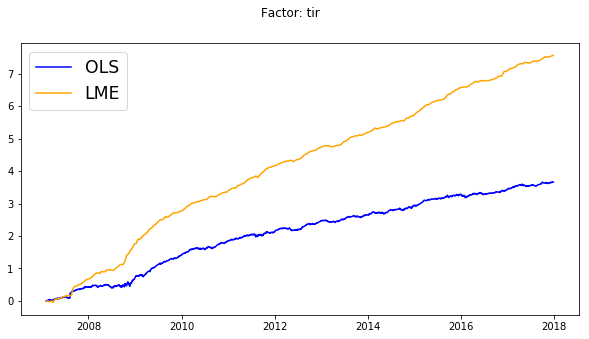

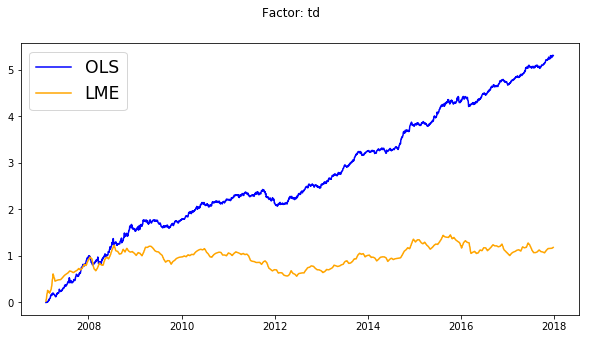

In [232]:
for factor_name in alpha_factors:
    fig = plt.figure(figsize=(10,5))
    fig.suptitle(f'Factor: {factor_name}')
    plt.plot(d[start:], f_rets_OLS.loc[start:,factor_name].cumsum().values, label='OLS', color='blue')
    plt.plot(d[start:], beta_lme[factor_name].cumsum().values, label='LME', color='orange')
    plt.legend(loc='best', fontsize='xx-large')

In [ ]:
def PnL_LME(FacMat, dfs, f_rets, theta, sigmaSq, start, end):
    PnL_LME = []
    hagg_LME = []
    hAvg_LME = 0
    nonAlpha = f_rets.columns[2:]
    count = -1
    for i in tqdm.tqdm_notebook(range(start,end)):
        n = len(FacMat[i])
        if i % 10 == 0:
            count += 1
            b = f_rets.iloc[count,:]
            # residual variance at time t
            resV = pow(np.ones(n)*sigmaSq[count],2)
            # Calculated expanding window covariance matrix for factor returns
            F = theta[count]
        else:
            # residual variance at time t
            resV = pow(np.ones(n)*sigmaSq[count],2)
            # Calculated expanding window covariance matrix for factor returns
            F = theta[count]
        b[nonAlpha] = 0
        # design matrix X
        X = FacMat[i].values
        # alpha factors
        alpha = X.dot(b.values[:,np.newaxis])
        # Optimal portfolio
        h = MarkowitzOptimize(resV, X, F, alpha, kappa = 1e-02)
        PnL_LME = np.append(PnL_LME, np.dot(h.T, dfs[i][returns_list]))
        hAvg_LME = (hAvg_LME*(i-1) + np.sum(abs(h)))/i
        hagg_LME.extend([h])
    PnL_LME = pd.DataFrame(PnL_LME, index=range(len(PnL_LME)))
    return PnL_LME, hAvg_LME, hagg_LME


In [ ]:
pnl_lme, havg_lme, hagg_lme = PnL_LME(FactorsMatrix, dfs, beta, theta, sigmaSq, start, len(FactorsMatrix))

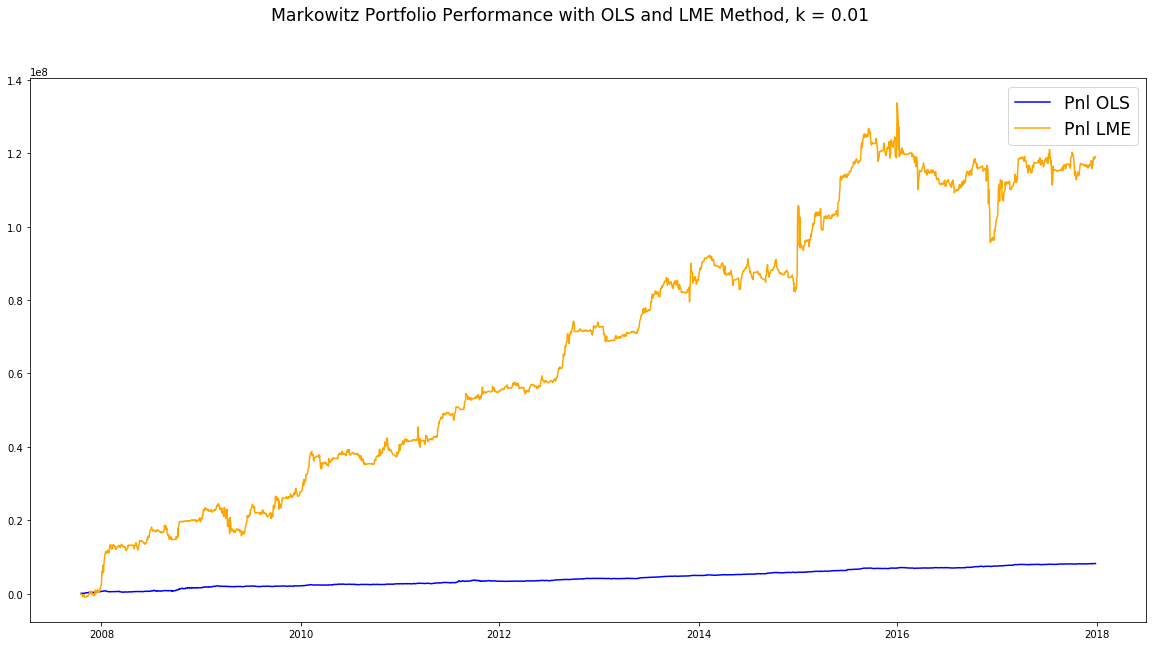

In [183]:
fig = plt.figure(figsize=(20,10))
fig.suptitle(f'Markowitz Portfolio Performance with OLS and LME Method, k = 0.01', fontsize='xx-large')
plt.plot(d[start:], pnl_before.cumsum().values, label='Pnl OLS', color='blue')
plt.plot(d[start:], pnl_lme.cumsum().values, label='Pnl LME', color='orange')
plt.legend(loc='best', fontsize='xx-large')

In [345]:
from qpsolvers import solve_qp

In [ ]:
def PnL_OLS_long(FacMat, dfs, f_rets, start, end):
    PnL_OLS_long = []
    for i in tqdm.tqdm_notebook(range(start,end)):
        n = len(FacMat[i])
        # alpha factors
        alpha = FacMat[i][alpha_factors].sum(axis=1).values
        # residual variance at time t
        resV = pow(dfs[i]['RESVOL'].values,2)
        D = np.diag(1/resV)
        # design matrix X
        X = FacMat[i].values
        # Calculated expanding window covariance matrix for factor returns
        F = f_rets.iloc[:i, :].cov().values
        # sigma
        sigma = D + X.dot(F.dot(X.T))
        # kappa
        kappa = 1e-02
        
        P = sigma.astype('double')
        q = alpha.astype('double')
        G = np.eye(n)*-1
        H = np.zeros(n)
        
        sol = solve_qp(P, q, G, H)
        
#         lb = list(np.zeros(n))
#         ub = list(np.ones(n)*np.inf)
#         bounds = Bounds(lb, ub)
#         def Markowitz(x):
#             return -x.T.dot(alpha) + (kappa/2) * x.T.dot(sigma.dot(x))
#         def der(x):
#             return alpha - kappa * sigma.dot(x)
#         h = np.ones(len(FacMat[i]))
#         res = minimize(Markowitz, h, method='trust-constr', jac=der,
#                        options={'verbose': 1}, bounds=bounds)
        h = sol[:,np.newaxis]
        # Compute daily PnL
        PnL_OLS_long = np.append(PnL_OLS_long, np.dot(h.T, dfs[i][returns_list]))
    PnL_OLS_long = pd.DataFrame(PnL_OLS_long, index=range(len(PnL)))
    return PnL_OLS_long

In [ ]:
def PnL_LME_long(FacMat, dfs, f_rets, theta, sigmaSq, start, end):
    PnL_LME_long = []
    for i in tqdm.tqdm_notebook(range(start,end)):
        n = len(FacMat[i])
        if i % 10 == 0:
            count += 1
            b = f_rets.iloc[count,:]
            # residual variance at time t
            resV = pow(np.ones(n)*sigmaSq[count],2)
            # Calculated expanding window covariance matrix for factor returns
            F = theta[count]
        else:
            # residual variance at time t
            resV = pow(np.ones(n)*sigmaSq[count],2)
            # Calculated expanding window covariance matrix for factor returns
            F = theta[count]
        b[nonAlpha] = 0
        # design matrix X
        X = FacMat[i].values
        # alpha factors
        alpha = X.dot(b.values[:,np.newaxis])
        D = np.diag(resV)
        # sigma
        sigma = D + X.dot(F.dot(X.T))
        # kappa
        kappa = 1e-02
        
        P = sigma.astype('double')
        q = alpha.astype('double')
        G = np.eye(n)*-1
        H = np.zeros(n)
        
        sol = solve_qp(P, q, G, H)
        
#         lb = list(np.zeros(n))
#         ub = list(np.ones(n)*np.inf)
#         bounds = Bounds(lb, ub)
#         def Markowitz(x):
#             return -x.T.dot(alpha) + (kappa/2) * x.T.dot(sigma.dot(x))
#         def der(x):
#             return alpha - kappa * sigma.dot(x)
#         h = np.ones(len(FacMat[i]))
#         res = minimize(Markowitz, h, method='trust-constr', jac=der,
#                        options={'verbose': 1}, bounds=bounds)
        h = sol[:,np.newaxis]
        # Compute daily PnL
        PnL_LME_long = np.append(PnL_LME_long, np.dot(h.T, dfs[i][returns_list]))
    PnL_LME_long = pd.DataFrame(PnL_LME_long, index=range(len(PnL_LME_long)))
    return PnL_LME_long

In [ ]:
pnl_ols_long = PnL_OLS_long(FactorsMatrix, dfs, f_rets_OLS, start, len(FactorsMatrix))

In [ ]:
pnl_lme_long = PnL_LME_long(FactorsMatrix, dfs, beta, theta, sigmaSq, start, len(FactorsMatrix))

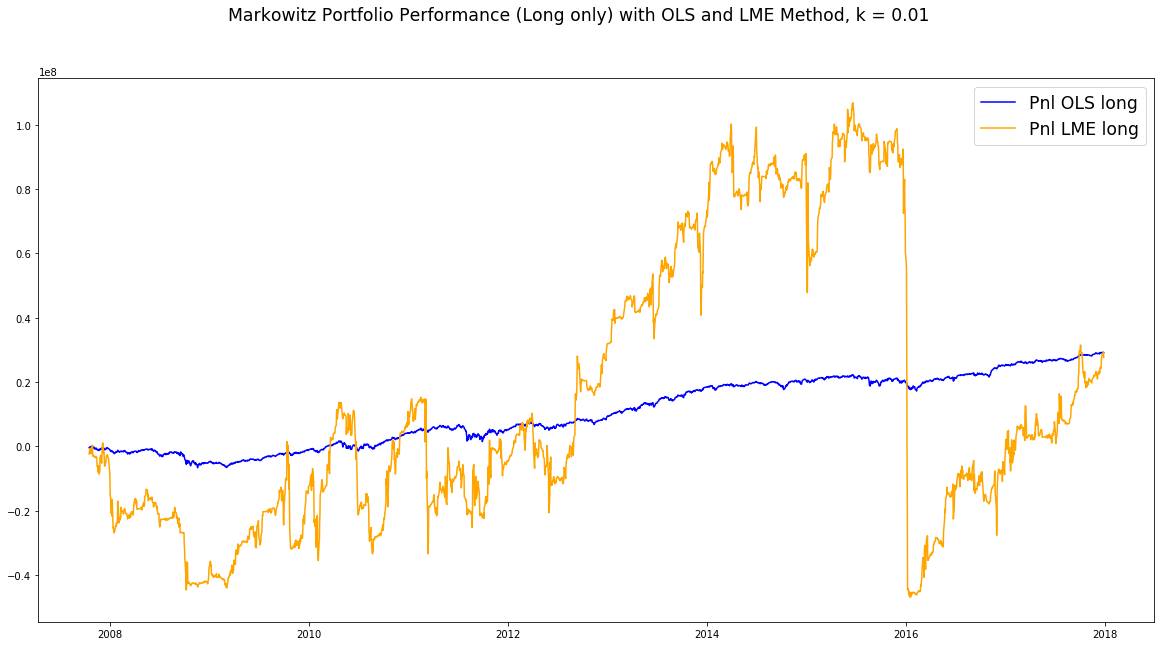

In [254]:
fig = plt.figure(figsize=(20,10))
fig.suptitle(f'Markowitz Portfolio Performance (Long only) with OLS and LME Method, k = 0.01', fontsize='xx-large')
plt.plot(d[start:], pnl_ols_long.cumsum().values, label='Pnl OLS long', color='blue')
plt.plot(d[start:], pnl_lme_long.cumsum().values, label='Pnl LME long', color='orange')
plt.legend(loc='best', fontsize='xx-large')

In [2]:
# Problem 4
class SimulatedPrices():
    def __init__(self, halflife, sigma, p0):
        self.halflife = halflife
        self.sigma = sigma
        self.p0 = p0
    
    # t is number of timesteps
    def simulation(self, t):
        # x(t) = log(p(t)/p(e))
        # Assume p(0) is 50, so start at equilibrium, so x(0) = 0
        lamb_da = np.log(2)/self.halflife
        # equilibrium price = 50
        pe = 50
        x0 = np.log(self.p0/pe)
        x = np.array([x0])
        rand = np.random.standard_normal(t)
        for i in range(t-1):
            dx = -lamb_da * x[i] + self.sigma * rand[i]
            x = np.append(x, x[i]+dx)
        prices = np.exp(x)*pe
        # times 10 so that possible price range under this process is 1 to 1000,
        # so as to match the state space in Q-learning
        return (prices*10).astype(int)

In [93]:
class Trading():
    # Action is lot size purchased
    def __init__(self, model, kappa, gamma, alpha, epsilon, K, M):
        self.model = model
        # Assume 100shares per lot
        self.lotSize = 100
        # Assum 0.1 tick size
        self.tickSize = 0.1
        self.kappa = kappa
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        # Number of lots allowed to trade
        self.K = K
        # Numer of position allowed to hold
        self.M = M
        self.action = self.actionSpace()
        self.states = self.stateSpace()
        # Store current shares position, initally to be 0
        self.shares = 0
        # Start at time 1
        self.time = 0
        # Simulation steps, will be supplied from reset() function
        self.t = 0
        # Chg in Cash account at time t
        self.cash = 0
        # Store increment port value at time t, defined as NAV(t) + Cash(t)
        self.value = 0
        
    def chgPnl(self, action):
        # since price is inflated by 10 in the simulation
        pnl = self.shares * (self.prices[self.time+1] - self.prices[self.time])/10 - self.cost(action)
        return pnl
    
    def cost(self, action):
        spreadCost = self.tickSize * abs(action)
        impactCost = pow(action,2) * self.tickSize/self.lotSize
        return spreadCost + impactCost
        
    def rewards(self, action):
        return self.chgPnl(action) - 0.5 * self.kappa * pow(self.chgPnl(action),2)
            
    def actionSpace(self):
        # K is number of lots
        # Action space is number of lots purchased
        # -500 ~ 500
        return np.arange(-self.K * self.lotSize, (self.K+1) * self.lotSize, self.lotSize)
    
    def stateSpace(self):
        # state spaces: s(t) = (p(t), n(t-1))
        # Dimension: H x P, (1000) * (2M + 1)
        # Prices: 0.1 ~ 100 (Same as 1 ~ 1000 divided by 10)
        priceSpace = np.arange(1,1001)
        # -10 ~ 10
        holdingSpace = np.arange(-self.M * self.lotSize, (self.M+1) * self.lotSize, self.lotSize)
        states = []
        for p in priceSpace:
            for h in holdingSpace:
                states.append((p,h))
        return states
    
    def step(self, action):
        # action is the index position in action space
        action = self.action[action]
        # Increment shares
        self.shares += action
        # Check if new state (shares) is out of state space (-1000 ~ 1000)
        if self.shares > (self.M*self.lotSize) or self.shares < (-self.M*self.lotSize):
            self.shares -= action
            # I always choose to do nothing (i.e. dont buy/sell) if out of state space
            action = 0
        reward = self.rewards(action)
        # increment time
        self.time += 1
        # Check if new state(price) is out of state space (1 ~ 1000)
        if self.prices[self.time] <= 1000 and self.prices[self.time] >= 1:
            # Get next states
            next_state = (self.prices[self.time], self.shares)
        # if price > 1000, assume its in state where price = 1000
        elif self.prices[self.time] > 1000:
            # Get next states
            next_state = (1000, self.shares)
        # if price < 1, assume its in state where price = 1
        else:
            # Get next states
            next_state = (1, self.shares)
        # Get index of that state corresponding to index of Q matrix
        next_index = self.states.index(next_state)
        terminate = False
        if self.time == (self.t-2):
            terminate = True
        return next_index, reward, terminate
        
    def reset(self, t):
        # Reset cash and position
        self.cash = 0
        self.value = 0
        # Reset state to initial state
        self.time = 0
        self.shares = 0
        self.t = t
        # Simulate new prices
        self.prices = self.model.simulation(t)
        init_states = (self.prices[self.time], self.shares)
        # Get index of that state corresponding to index of Q matrix
        init_index = self.states.index(init_states)
        return init_index
    
    def simulatedTrading(self, Q, t):
        # pnl
        pnl = []
        returns = []
        # initialize state
        state = self.reset(t)
        
        for i in range(t-1):
            print('Calculating [%d%%]\r'%(float(i)/t), end="")
            best_action = np.argmax(Q[state])
            # best_action is the index position in action space
            best_action = self.action[best_action]
            self.shares += best_action
            if self.shares > (self.M*self.lotSize) or self.shares < (-self.M*self.lotSize):
                self.shares -= best_action
                # I always choose to do nothing (i.e. dont buy/sell) if out of state space
                best_action = 0
            # Chg in Cash account at time t
            self.cash = -best_action * self.prices[self.time]
            # Value is NAV(t) + Cash(t)
            self.value = self.shares * self.prices[self.time] + self.cash
            dailyPnl = self.chgPnl(best_action)
            pnl = np.append(pnl, dailyPnl)
            returns = np.append(returns, dailyPnl/self.value if self.value != 0 else 0)
            # increment time
            self.time += 1
            # Check if new state(price) is out of state space (1 ~ 1000)
            if self.prices[self.time] <= 1000 and self.prices[self.time] >= 1:
                # Get next states
                next_state = (self.prices[self.time], self.shares)
            # if price > 1000, assume its in state where price = 1000
            elif self.prices[self.time] > 1000:
                # Get next states
                next_state = (1000, self.shares)
            # if price < 1, assume its in state where price = 1
            else:
                # Get next states
                next_state = (1, self.shares)
            # Get index of that state corresponding to index of Q matrix
            next_index = self.states.index(next_state)
            state = next_index
        return pnl, returns

In [4]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 

    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array  
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state):
        Action_probabilities = np.ones(num_actions,
                                       dtype = float) * epsilon / num_actions 

        best_action = np.argmax(Q[state])
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities

    return policyFunction

# env is Trading
def QLearning(env, t):
    # initialize Q matrix to be zeros
    Q = np.zeros((len(env.states),len(env.action)))
    
    # Create the epsilon greedy policy function
    policy = createEpsilonGreedyPolicy(Q, env.epsilon, len(env.action))

    # Reset state to initial state
    state = env.reset(t) 
    
    # Keeps looping until end of states
    for i in range(t): 

        # get probabilities of all actions from current state 
        action_probabilities = policy(state) 

        # choose action according to  
        # the probability distribution 
        action = np.random.choice(np.arange(len(action_probabilities)), 
                                  p = action_probabilities) 

        # take action, transit to next state , get reward
        next_state, reward, terminate = env.step(action) 

        # TD Update 
        best_next_action = np.argmax(Q[next_state])     
        td_target = reward + env.gamma * Q[next_state][best_next_action] 
        td_delta = td_target - Q[state][action] 
        Q[state][action] += env.alpha * td_delta 

        # done is True if terminate condition is met    
        if terminate: 
            break
            
        state = next_state 
    return Q

In [71]:
model = SimulatedPrices(5,0.1,50)

In [94]:
kappa = 1e-4
gamma = 0.999
alpha = 0.001
epsilon = 0.1
K = 5
M = 10
trading = Trading(model, kappa, gamma, alpha, epsilon, K, M)

In [54]:
Q = QLearning(trading, 500000)

In [95]:
pnl, ret = trading.simulatedTrading(Q,500000)

In [96]:
# num of tradings days per year
N = 252
sharpe = N * np.mean(ret) / (np.sqrt(N) * np.var(ret))

In [97]:
sharpe

70.31021905604848

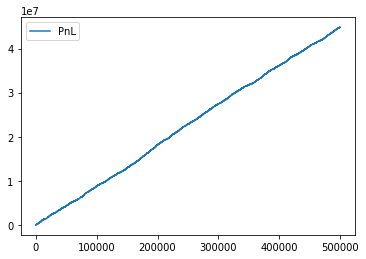

In [102]:
plt.plot(pnl.cumsum(), label="PnL")
plt.legend(loc='best')